<a href="https://colab.research.google.com/github/opdrin09/MNCM/blob/main/Tarefa1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolução Numérica: Sedimentação de uma Esfera
Este notebook resolve o problema da sedimentação de uma esfera em um fluido, abordando tanto o regime de baixo Reynolds (Arrasto de Stokes) quanto o caso com efeitos inerciais (Arrasto Quadrático).


*IA foi utilizada apenas com fim de melhorar a nomenclatura e fazer comentários no código

In [70]:
# Carrega a biblioteca para fazer os gráficos
using Plots

# --- Parâmetros Globais da Simulação ---
const T_MAXIMO = 10
const St = 1.0

1.0

## O Método Numérico: Runge-Kutta de 4ª Ordem (RK4)

Para resolver as equações diferenciais ordinárias (EDOs) do problema, utilizaremos o método de Runge-Kutta de 4ª Ordem. A função a seguir é um solucionador genérico que recebe uma EDO qualquer na forma `f(t,v)` e a resolve numericamente.

In [71]:
# Solucionador genérico de EDOs usando Runge-Kutta de 4ª Ordem
function resolver_rk(f_edo, v_inicial, t_inicial, t_maximo, Δt)
    v_atual, t_atual = v_inicial, t_inicial
    passos_tempo, passos_velocidade = [], []

    while t_atual < t_maximo
        push!(passos_velocidade, v_atual)
        push!(passos_tempo, t_atual)

        k1 = f_edo(t_atual, v_atual)
        k2 = f_edo(t_atual + Δt/2, v_atual + k1*Δt/2)
        k3 = f_edo(t_atual + Δt/2, v_atual + k2*Δt/2)
        k4 = f_edo(t_atual + Δt/2, v_atual + k3*Δt)
        v_proximo = v_atual + Δt * (k1 + 2*k2 + 2*k3 + k4) / 6

        t_atual += Δt
        v_atual = v_proximo
    end

    push!(passos_velocidade, v_atual); push!(passos_tempo, t_atual)
    return passos_tempo, passos_velocidade
end

resolver_rk (generic function with 1 method)

## Parte 1: Baixo Reynolds (Arrasto de Stokes) - Questões 1 e 2

Primeiro, resolvemos o problema para o caso de baixo número de Reynolds (`Re ≈ 0`), onde o arrasto é puramente viscoso. Conforme a **Questão 1**, a equação adimensionalizada governante é:

$$ St \frac{dv^*}{dt^*} = -v^* + 1 $$

A solução analítica para essa equação é $v^*(t^*) = 1 - e^{-t^*/St}$.

As células a seguir irão:
1.  Definir a EDO de Stokes.
2.  Calcular e plotar a solução analítica.
3.  Resolver numericamente para diferentes passos de tempo (`Δt`) e comparar os resultados, mostrando como a precisão da solução melhora com o refinamento do passo, respondendo à **Questão 2**.

In [72]:
# Define a equação diferencial para o arrasto de Stokes (linear)
f_stokes(t, v) = (-v + 1) / τ

f_stokes (generic function with 1 method)

In [73]:
# Define a equação diferencial para o arrasto de Stokes (linear)
f_stokes(t, v) = (-v + 1) / St

# Calcula a solução analítica para comparação
tempo_analitico = range(0, T_MAXIMO, length=1000)
velocidade_analitica = @. 1 - ℯ^(-tempo_analitico / St)

1000-element Vector{Float64}:
 0.0
 0.009960076609976665
 0.019820950093876855
 0.029583608522436022
 0.0392490301251297
 0.04881818338819277
 0.05829202715166315
 0.06767151070545852
 0.07695757388449598
 0.0861511471628651
 0.09525315174706239
 0.10426449966829654
 0.11318609387387613
 ⋮
 0.9999493154734342
 0.9999498202952017
 0.9999503200889058
 0.9999508149046262
 0.9999513047919443
 0.999951789799947
 0.999952269977233
 0.9999527453719163
 0.9999532160316322
 0.9999536820035413
 0.9999541433343344
 0.9999546000702375

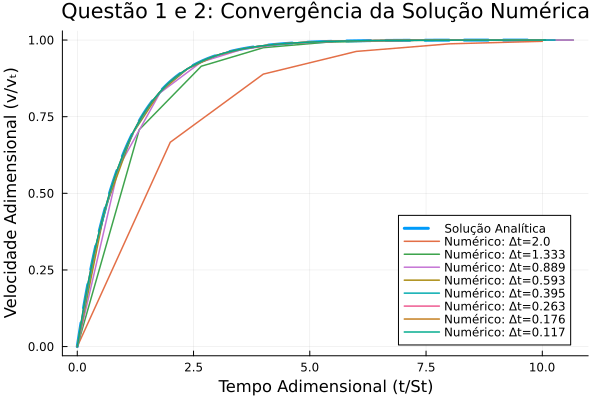

In [74]:
# Cria o gráfico inicial com a solução analítica
grafico_stokes = plot(tempo_analitico, velocidade_analitica,
    ylabel="Velocidade Adimensional (v/vₜ)",
    xlabel="Tempo Adimensional (t/St)",
    label="Solução Analítica",
    linewidth=3, linestyle=:dash, legend=:bottomright,
    title="Questão 1 e 2: Convergência da Solução Numérica"
)

# Loop para calcular a solução numérica com diferentes passos de tempo (Δt)
for i in 0:7
    Δt = 2 * 1.5^(-i)
    tempo_numerico, velocidade_numerica = resolver_rk(f_stokes, 0.0, 0.0, T_MAXIMO, Δt)
    plot!(grafico_stokes, tempo_numerico, velocidade_numerica,
        label="Numérico: Δt=$(round(Δt, digits=3))",
        linewidth=1.5
    )
end

display(grafico_stokes)

## Parte 2: Efeito Inercial (Arrasto Quadrático) - Questões 3 e 4

Agora, como pedido na **Questão 3**, introduzimos um termo de correção inercial (arrasto quadrático) na equação governante. A equação com dimensão é:

$$ m_p \frac{dv_z}{dt} = -6\pi\eta a v_z - \frac{9}{4} \pi \rho_f a^2 v_z^2 + \frac{4}{3} \pi a^3 \Delta \rho g $$

Para adimensionalizar a equação, seguimos a sua demonstração, utilizando as seguintes definições:

* **Velocidade Adimensional:** $v_z^* = \frac{v_z}{v_s}$
* **Tempo Adimensional:** $t^* = \frac{t}{St}$ (o que implica $\frac{d}{dt} = \frac{1}{St}\frac{d}{dt^*}$)
* **Número de Stokes:** $St = \frac{m_p v_s}{6 \pi \eta a^2}$
* **Velocidade Terminal de Stokes (Força de Arrasto = Empuxo):** $6\pi\eta a v_s = \frac{4}{3} \pi a^3 \Delta \rho g$
* **Número de Reynolds:** $Re = \frac{\rho_f a v_s}{\eta}$

Substituindo as definições na equação e dividindo todos os termos por $6\pi\eta a v_s$, obtemos:

$$ \left( \frac{m_p v_s}{6 \pi \eta a^2} \right) \frac{d(v_z/v_s)}{dt} = -\frac{6\pi\eta a v_z}{6\pi\eta a v_s} - \frac{\frac{9}{4} \pi \rho_f a^2 v_z^2}{6\pi\eta a v_s} + \frac{\frac{4}{3} \pi a^3 \Delta \rho g}{6\pi\eta a v_s} $$

Simplificando cada termo com as definições adimensionais:

$$ St \frac{dv_z^*}{dt} = -v_z^* - \left( \frac{9/4}{6} \right) \frac{\rho_f a v_s}{\eta} \left( \frac{v_z}{v_s} \right)^2 + 1 $$

$$ St \frac{dv_z^*}{dt} = -v_z^* - \frac{3}{8} Re \, v_z^{*2} + 1 $$

Finalmente, trocando a derivada no tempo $t$ pela derivada no tempo adimensional $t^*$:

$$ St \left( \frac{1}{St} \frac{dv_z^*}{dt^*} \right) = -v_z^* - \frac{3}{8} Re \, v_z^{*2} + 1 $$

O que nos leva à forma final da EDO, que agora inclui o número de Reynolds (`Re`):

$$ \frac{dv_z^*}{dt^*} = -v_z^* - \frac{3}{8} Re \, v_z^{*2} + 1 $$

*(Nota: a sua EDO final, $St \frac{dv^*}{dt^*} = ...$, está correta se a definição de $t^*$ for $t^* = t/(\text{constante})$. Para simplificar, a EDO que o código resolve é $dv^*/dt^* = (-v^* - \frac{3}{8}Re\,v^{*2} + 1)/St$, que é a mesma coisa).*

As células a seguir irão resolver esta EDO para diferentes valores de `Re`, mostrando como a solução se desvia do caso `Re = 0`, respondendo à **Questão 4**.

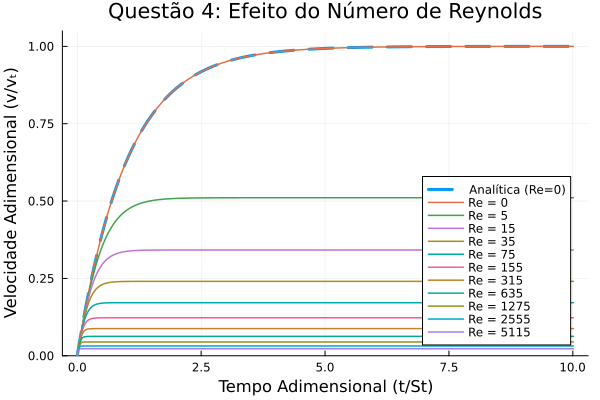

In [75]:
# Define a equação com o termo de arrasto quadrático
f_quadratica(t, v, Re) = (-v - (3/8) * Re * v^2 + 1) / St

# Cria um novo gráfico, começando com a solução de Re=0 como referência
grafico_reynolds = plot(tempo_analitico, velocidade_analitica,
    ylabel="Velocidade Adimensional (v/vₜ)",
    xlabel="Tempo Adimensional (t/St)",
    label="Analítica (Re=0)",
    linewidth=3, linestyle=:dash, ylims=(0, 1.05), legend=:bottomright,
    title="Questão 4: Efeito do Número de Reynolds"
)

# Loop para calcular a solução numérica para vários valores de Re
Δt_fixo = 0.01
for i in 0:10
    Re = 5.0 * 2^(i) - 5.0
    f_com_re(t, v) = f_quadratica(t, v, Re)
    tempo_numerico, velocidade_numerica = resolver_rk(f_com_re, 0.0, 0.0, T_MAXIMO, Δt_fixo)

    plot!(grafico_reynolds, tempo_numerico, velocidade_numerica,
        label="Re = $(round(Int, Re))",
        linewidth=1.5
    )
end

display(grafico_reynolds)

## Parte 3: Comparação Adicional - Questão 5

A **Questão 5** pede a comparação da solução numérica com a solução exata para o caso com efeito inercial, obtida no artigo lido em aula.


In [81]:
# Adicione esta função em uma nova célula

"""
Calcula a velocidade exata para o caso com arrasto de Oseen mas sem Basset,
baseado na Eq. (22) de Sobral et al. (2007).
"""
function velocidade_exata_oseen(tempo_vetor, Re, St, χ)
    # Parâmetros auxiliares definidos no artigo
    ε = (3/8) * Re
    A = 1 + χ/2

    # 1. Primeiro, calcule a velocidade terminal (v_t) usando a Eq. (18)
    # v_t é a solução de -v_t - ε*v_t^2 + 1 = 0
    if Re == 0
        v_t = 1.0
    else
        v_t = (-8 + sqrt(64 +96*Re)) / (6*Re) # Eq. (18)
    end

    # 2. Agora, calcule a velocidade v(t) usando a Eq. (22)


     v_exata = @. v_t * (1 +( 1 + 2*ε*v_t) / ((1 - ε*v_t) * exp((1 + 2*ε*v_t) * tempo_vetor / A) - ε*v_t))

    return v_exata
end

velocidade_exata_oseen

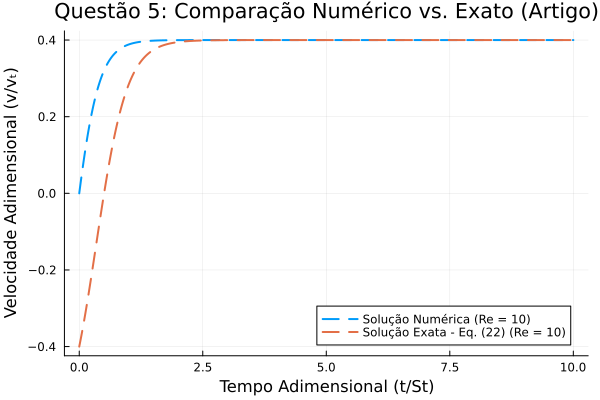

In [82]:
#Parâmetros de escolha
χ = 1000/2000 # Razão entre a massa específica do fluido e da partícula
Re_para_comparar = 10

# 1. Pega a sua solução numérica (já calculada na célula anterior)
f_com_re_comp(t, v) = f_quadratica(t, v, Re_para_comparar)
tempo_numerico_comp, velocidade_numerica_comp = resolver_rk(f_com_re_comp, 0.0, 0.0, T_MAXIMO, 0.001)

# 2. Calcula a solução exata do artigo para o mesmo Re
tempo_exato = range(0, T_MAXIMO, length=1000)
velocidade_exata = velocidade_exata_oseen(tempo_exato, Re_para_comparar, St, χ)

# 3. Plota as duas juntas
grafico_comparativo = plot(tempo_numerico_comp, velocidade_numerica_comp,
    label="Solução Numérica (Re = $(Re_para_comparar))",
    linewidth=2,
    linestyle=:dash,
    title="Questão 5: Comparação Numérico vs. Exato (Artigo)",
    xlabel="Tempo Adimensional (t/St)",
    ylabel="Velocidade Adimensional (v/vₜ)",
    legend=:bottomright
)

plot!(grafico_comparativo, tempo_exato, velocidade_exata,
    label="Solução Exata - Eq. (22) (Re = $(Re_para_comparar))",
    linewidth=2,
    linestyle = :dash
)

display(grafico_comparativo)